## Load Data from MySQL

In [1]:
from sqlalchemy import create_engine
import pymysql
import pandas as pd
from functools import reduce

In [2]:
# Compiling login info
pw = %env DB_PW
DB_TYPE = 'mysql'
DB_DRIVER = 'pymysql'
DB_USER = 'root' # your username in the mysql server
DB_PASS = pw # your password in the mysql server
DB_HOST = 'localhost' # change to hostname of your server if on cloud
DB_PORT = '3306' # change accordingly
DB_NAME = 'bank' # name of your database
POOL_SIZE = 50

In [3]:
SQLALCHEMY_DATABASE_URI = f'{DB_TYPE}+{DB_DRIVER}://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
# Creating engine with login info
engine = create_engine(SQLALCHEMY_DATABASE_URI, pool_size=POOL_SIZE, max_overflow=0)

# this connects to the sql engine
connection = engine.connect()

#### Loan View

In [4]:
loan = pd.read_sql('select * from defaultView',con=connection)
loan.head()

,loanId,accountId,date,amount,duration,payments,status,owner,ownerAge,hasDisponent,...,municipalities2k,municipalities10k,cities,urbanRatio,avgSalary,unemploymentRate95,unemploymentRate96,entrepreneurP1k,crimes95,crimes96
0,4959,2,1994-01-05,80952.0,24,3373.0,A,Male,54,1,...,0,1,1,100.0,12541,0.0,0.0,167,85677,99107
1,4961,19,1996-04-29,30276.0,12,2523.0,B,Female,60,0,...,7,1,7,67.0,9104,2.0,2.0,123,2299,2354
2,4962,25,1997-12-08,30276.0,12,2523.0,A,Male,37,0,...,18,2,6,57.0,9893,4.0,5.0,96,5623,5887
3,4967,37,1998-10-14,318480.0,60,5308.0,D,Male,47,0,...,3,1,4,58.0,8547,3.0,4.0,120,1563,1542
4,4968,38,1998-04-19,110736.0,48,2307.0,C,Female,59,0,...,3,1,4,53.0,8402,3.0,4.0,120,999,1099


#### Transactions View
 - Only transaction prior to loan date, avoid future info

In [5]:
trans = pd.read_sql('select * from transBeforeLoanView',con=connection)
trans.head()

,transId,accountId,date,type,operation,amount,balance,kSymbol,bankTo,accountTo
0,276,2,1993-02-26,PRIJEM,VKLAD,1100.0,1100.0,,,0
1,279,2,1993-03-12,PRIJEM,PREVOD Z UCTU,20236.0,21336.0,,ST,66487163
2,280,2,1993-04-12,PRIJEM,PREVOD Z UCTU,20236.0,45286.0,,ST,66487163
3,281,2,1993-05-12,PRIJEM,PREVOD Z UCTU,20236.0,54631.0,,ST,66487163
4,282,2,1993-06-12,PRIJEM,PREVOD Z UCTU,30354.0,67530.0,,ST,66487163


In [6]:
connection.close()
engine.dispose()

## Combine the 2 views into 1 DataFrame
Aggregate the transactions at client level

In [22]:
tmp = trans.groupby('accountId').balance.agg(['min','mean'])
tmp['balance5kCount'] = trans[trans['balance']<5000].groupby('accountId').balance.agg('count')
tmp['balance1kCount'] = trans[trans['balance']<1000].groupby('accountId').balance.agg('count')
tmp['balanceNegCount'] = trans[trans['balance']<0].groupby('accountId').balance.agg('count')
tmp.head()

,min,mean,balance5kCount,balance1kCount,balanceNegCount
accountId,,,,,
2,1100.0,32590.759259,1.0,NaN,NaN
19,715.0,25197.137500,10.0,1.0,NaN
25,900.0,62991.408537,1.0,1.0,NaN
37,-1011.0,39954.034483,3.0,2.0,1.0
38,13841.0,31383.581818,NaN,NaN,NaN


In [23]:
df = pd.merge(loan, tmp, on='accountId', how='left')
df.head()

,loanId,accountId,date,amount,duration,payments,status,owner,ownerAge,hasDisponent,...,unemploymentRate95,unemploymentRate96,entrepreneurP1k,crimes95,crimes96,min,mean,balance5kCount,balance1kCount,balanceNegCount
0,4959,2,1994-01-05,80952.0,24,3373.0,A,Male,54,1,...,0.0,0.0,167,85677,99107,1100.0,32590.759259,1.0,NaN,NaN
1,4961,19,1996-04-29,30276.0,12,2523.0,B,Female,60,0,...,2.0,2.0,123,2299,2354,715.0,25197.137500,10.0,1.0,NaN
2,4962,25,1997-12-08,30276.0,12,2523.0,A,Male,37,0,...,4.0,5.0,96,5623,5887,900.0,62991.408537,1.0,1.0,NaN
3,4967,37,1998-10-14,318480.0,60,5308.0,D,Male,47,0,...,3.0,4.0,120,1563,1542,-1011.0,39954.034483,3.0,2.0,1.0
4,4968,38,1998-04-19,110736.0,48,2307.0,C,Female,59,0,...,3.0,4.0,120,999,1099,13841.0,31383.581818,NaN,NaN,NaN


## Clean the data

In [267]:
df.columns.unique()

Index(['amount', 'duration', 'payments', 'status', 'ownerAge', 'hasDisponent',
       'creditCard', 'inhabitants', 'municipalities', 'municipalities500',
       'municipalities2k', 'municipalities10k', 'cities', 'urbanRatio',
       'avgSalary', 'unemploymentRate95', 'unemploymentRate96',
       'entrepreneurP1k', 'crimes95', 'crimes96', 'min', 'mean',
       'balance5kCount', 'balance1kCount', 'balanceNegCount', 'owner_Male'],
      dtype='object')

In [24]:
df = df.drop(columns=['loanId','accountId','date','districtId','name','region'])

In [25]:
df['creditCard'] = df['creditCard'].map({"gold": 3, "classic": 2, "junior": 1})

In [26]:
df.fillna(0, inplace=True)
df.head()

,amount,duration,payments,status,owner,ownerAge,hasDisponent,creditCard,inhabitants,municipalities,...,unemploymentRate95,unemploymentRate96,entrepreneurP1k,crimes95,crimes96,min,mean,balance5kCount,balance1kCount,balanceNegCount
0,80952.0,24,3373.0,A,Male,54,1,0.0,1204953,0,...,0.0,0.0,167,85677,99107,1100.0,32590.759259,1.0,0.0,0.0
1,30276.0,12,2523.0,B,Female,60,0,0.0,103347,87,...,2.0,2.0,123,2299,2354,715.0,25197.137500,10.0,1.0,0.0
2,30276.0,12,2523.0,A,Male,37,0,0.0,228848,15,...,4.0,5.0,96,5623,5887,900.0,62991.408537,1.0,1.0,0.0
3,318480.0,60,5308.0,D,Male,47,0,0.0,70646,94,...,3.0,4.0,120,1563,1542,-1011.0,39954.034483,3.0,2.0,1.0
4,110736.0,48,2307.0,C,Female,59,0,0.0,51428,50,...,3.0,4.0,120,999,1099,13841.0,31383.581818,0.0,0.0,0.0


In [14]:
df.describe()

,amount,duration,payments,ownerAge,hasDisponent,creditCard,inhabitants,municipalities,municipalities500,municipalities2k,...,avgSalary,unemploymentRate95,unemploymentRate96,entrepreneurP1k,crimes95,crimes96,min,mean,balance5kCount,balance1kCount
count,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,6.820000e+02,682.000000,682.000000,682.000000,...,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000
mean,151410.175953,36.492669,4190.664223,40.901760,0.212610,0.491202,2.720522e+05,39.673021,21.557185,5.648094,...,9502.986804,2.890029,3.480938,121.218475,14687.291789,16390.818182,656.146628,43606.833097,1.649560,1.079179
std,113372.406310,17.075219,2215.830344,12.688891,0.409454,0.884229,3.583320e+05,33.673348,15.780258,4.588747,...,1323.150982,1.965470,2.245652,23.366091,26960.552702,31299.743394,1845.906425,13481.860726,3.103985,1.871701
min,4980.000000,12.000000,304.000000,19.000000,0.000000,0.000000,4.282100e+04,0.000000,0.000000,0.000000,...,8110.000000,0.000000,0.000000,81.000000,0.000000,888.000000,-17030.000000,5350.000000,0.000000,0.000000
25%,66732.000000,24.000000,2477.000000,30.000000,0.000000,0.000000,9.208400e+04,5.000000,10.000000,2.000000,...,8544.000000,2.000000,2.000000,106.000000,2159.000000,2305.000000,305.250000,32833.081400,1.000000,1.000000
50%,116928.000000,36.000000,3934.000000,41.000000,0.000000,0.000000,1.246050e+05,35.000000,23.000000,5.000000,...,8991.000000,3.000000,3.000000,116.000000,3729.000000,3868.000000,600.000000,43159.288363,1.000000,1.000000
75%,210654.000000,48.000000,5813.500000,52.000000,0.000000,0.000000,2.261220e+05,65.000000,33.000000,8.000000,...,9897.000000,4.000000,5.000000,132.000000,6949.000000,6872.000000,900.000000,53614.015301,1.000000,1.000000
max,590820.000000,60.000000,9910.000000,64.000000,1.000000,3.000000,1.204953e+06,151.000000,70.000000,20.000000,...,12541.000000,7.000000,9.000000,167.000000,85677.000000,99107.000000,20574.000000,79500.529762,57.000000,38.000000


In [266]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 0 to 681
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   amount              682 non-null    float64
 1   duration            682 non-null    int64  
 2   payments            682 non-null    float64
 3   status              682 non-null    int64  
 4   ownerAge            682 non-null    int64  
 5   hasDisponent        682 non-null    int64  
 6   creditCard          682 non-null    float64
 7   inhabitants         682 non-null    int64  
 8   municipalities      682 non-null    int64  
 9   municipalities500   682 non-null    int64  
 10  municipalities2k    682 non-null    int64  
 11  municipalities10k   682 non-null    int64  
 12  cities              682 non-null    int64  
 13  urbanRatio          682 non-null    float64
 14  avgSalary           682 non-null    int64  
 15  unemploymentRate95  682 non-null    float64
 16  unemploy

## Label
 - A: contract finished, no problems
 - B: contract finished, loan not payed (default)
 - C: running contract, OK so far
 - D: client in debt
 
 A and C = label 0 : no default
 
 B and D = label 1 : default

In [27]:
m = {"A": 0, "B": 1, "C": 0, "D": 1}
df['status'] = df['status'].map(m)

In [28]:
df.head()

,amount,duration,payments,status,owner,ownerAge,hasDisponent,creditCard,inhabitants,municipalities,...,unemploymentRate95,unemploymentRate96,entrepreneurP1k,crimes95,crimes96,min,mean,balance5kCount,balance1kCount,balanceNegCount
0,80952.0,24,3373.0,0,Male,54,1,0.0,1204953,0,...,0.0,0.0,167,85677,99107,1100.0,32590.759259,1.0,0.0,0.0
1,30276.0,12,2523.0,1,Female,60,0,0.0,103347,87,...,2.0,2.0,123,2299,2354,715.0,25197.137500,10.0,1.0,0.0
2,30276.0,12,2523.0,0,Male,37,0,0.0,228848,15,...,4.0,5.0,96,5623,5887,900.0,62991.408537,1.0,1.0,0.0
3,318480.0,60,5308.0,1,Male,47,0,0.0,70646,94,...,3.0,4.0,120,1563,1542,-1011.0,39954.034483,3.0,2.0,1.0
4,110736.0,48,2307.0,0,Female,59,0,0.0,51428,50,...,3.0,4.0,120,999,1099,13841.0,31383.581818,0.0,0.0,0.0


## Encoding

In [29]:
df = pd.get_dummies(df, drop_first=True)

## Split

In [320]:
X = df.loc[:, df.columns != "status"]
y = df.loc[:, "status"]

In [321]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y,random_state=42)

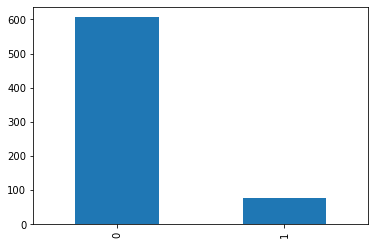

In [31]:
# imbalanced dataset
fig = y.value_counts().plot(kind='bar');
fig.figure.savefig('status.png')

In [205]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scikitplot as skplt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

## Scale

In [322]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pd.DataFrame(X_train_scaled).head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.143628,0.75,0.153944,0.511111,0.0,0.0,0.002489,0.344371,0.142857,0.25,...,0.444444,0.372093,0.009547,0.000000,0.524379,0.277719,0.017544,0.026316,0.000000,0.0
1,0.548311,0.50,0.851887,0.355556,0.0,0.0,0.021062,0.470199,0.271429,0.50,...,0.111111,0.337209,0.012010,0.002433,0.518397,0.391616,0.017544,0.026316,0.000000,1.0
2,0.732806,1.00,0.672180,0.444444,0.0,0.0,0.241839,0.000000,0.000000,0.00,...,0.555556,0.220930,0.219219,0.177756,0.521388,0.790925,0.017544,0.026316,0.000000,0.0
3,0.174576,0.25,0.413062,0.933333,0.0,0.0,0.051447,0.496689,0.471429,0.10,...,0.555556,0.151163,0.024779,0.012686,0.462399,0.290291,0.280702,0.394737,0.451613,1.0
4,0.535109,1.00,0.485793,0.044444,0.0,0.0,0.082771,0.390728,0.585714,0.40,...,0.333333,0.313953,0.029926,0.019457,0.533353,0.604990,0.017544,0.026316,0.000000,0.0


In [243]:
def eval(model):
    y_pred = model.predict(X_test_scaled)
    print(classification_report(y_test, y_pred))
    skplt.metrics.plot_confusion_matrix(y_test, y_pred)

## Benchmark
using Decision Tree

In [239]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       182
           1       0.52      0.61      0.56        23

    accuracy                           0.89       205
   macro avg       0.73      0.77      0.75       205
weighted avg       0.90      0.89      0.90       205



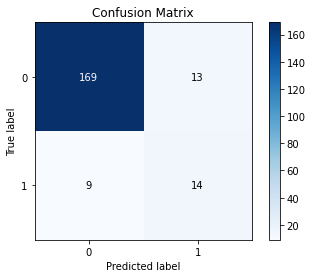

In [254]:
base = DecisionTreeClassifier(random_state=42)
base.fit(X_train_scaled,y_train)
eval(base)

## Over Sampling

              precision    recall  f1-score   support

           0       0.95      0.90      0.93       182
           1       0.45      0.65      0.54        23

    accuracy                           0.87       205
   macro avg       0.70      0.78      0.73       205
weighted avg       0.90      0.87      0.88       205



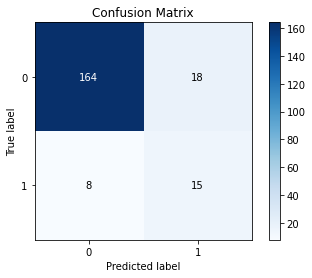

In [298]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN

# define pipeline
over = ADASYN()
steps = [('over', over), ('model', base)]
pipeline = Pipeline(steps=[('over', over), ('model', base)])
# evaluate pipeline
pipeline.fit(X_train_scaled,y_train)
eval(pipeline)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       182
           1       0.52      0.70      0.59        23

    accuracy                           0.89       205
   macro avg       0.74      0.81      0.77       205
weighted avg       0.91      0.89      0.90       205



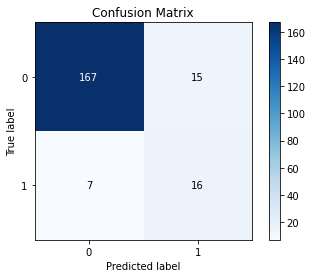

In [297]:
# define pipeline
over = SMOTE()
steps = [('over', over), ('model', base)]
pipeline = Pipeline(steps=[('over', over), ('model', base)])
# evaluate pipeline
pipeline.fit(X_train_scaled,y_train)
eval(pipeline)

In [323]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

## Logistic Regression

              precision    recall  f1-score   support

           0       0.97      0.87      0.92       182
           1       0.44      0.78      0.56        23

    accuracy                           0.86       205
   macro avg       0.70      0.83      0.74       205
weighted avg       0.91      0.86      0.88       205



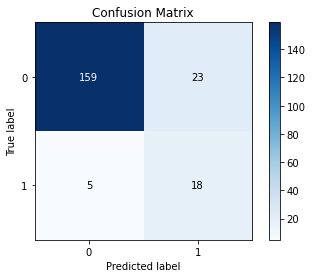

In [353]:
from sklearn.linear_model import LogisticRegression
lr =LogisticRegression(C=1000)
# evaluate pipeline
lr.fit(X_res,y_res)
eval(lr)

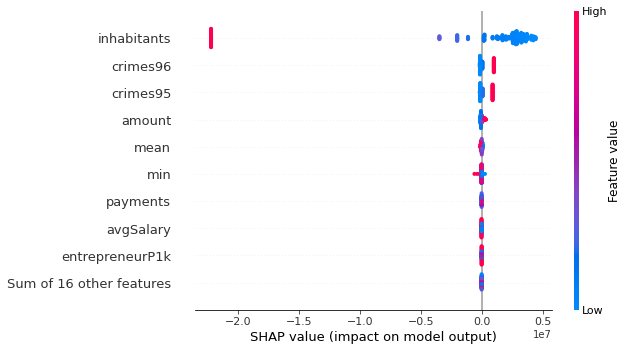

In [362]:
import shap
shap.initjs()
explainer = shap.Explainer(lr, X_train, feature_names=X.columns)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

Feature: 0, Score: -4.00250
Feature: 1, Score: -56.80263
Feature: 2, Score: -9.89962
Feature: 3, Score: 4.10414
Feature: 4, Score: -1.26965
Feature: 5, Score: -4.75675


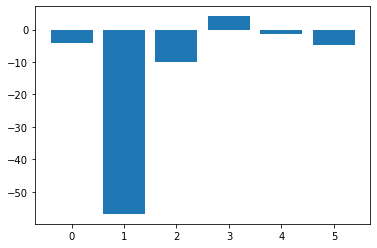

Index(['amount', 'hasDisponent', 'ownerAge'], dtype='object')


In [338]:
importance = lr.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()
top_three = np.argpartition(importance, -3)[-3:]
top_three_sorted=top_three[np.argsort(importance[top_three])]
print(X.columns[top_three_sorted])

## Decision Tree

{'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       182
           1       0.52      0.74      0.61        23

    accuracy                           0.89       205
   macro avg       0.74      0.83      0.77       205
weighted avg       0.91      0.89      0.90       205



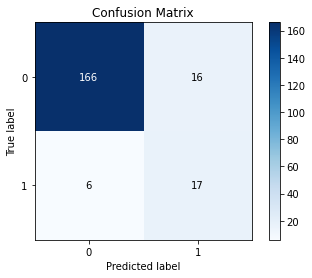

In [315]:
max_depth = range(2,20,2)

parameters = {
    'max_depth': max_depth,
    'criterion': ['gini', 'entropy'],
    'min_samples_split': range(2, 100,10)
}

tree = DecisionTreeClassifier(random_state=42,class_weight='balanced')
gs = GridSearchCV(tree, parameters, cv=StratifiedKFold(n_splits=5), scoring='recall', n_jobs=-1)
gs.fit(X_res,y_res)
print(gs.best_params_)
eval(gs.best_estimator_)

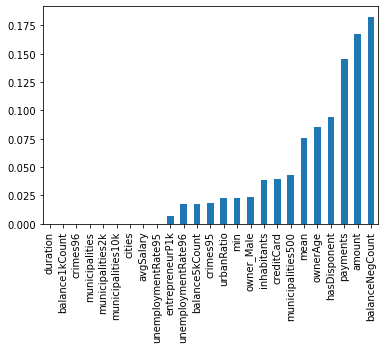

In [259]:
pd.Series(best_model.feature_importances_, index=X.columns).sort_values().plot(kind='bar');

## Random Forest

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.6min finished
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       182
           1       0.62      0.70      0.65        23

    accuracy                           0.92       205
   macro avg       0.79      0.82      0.80       205
weighted avg       0.92      0.92      0.92       205



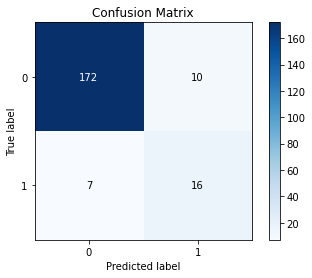

In [316]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier(class_weight='balanced')
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='f1', n_iter = 100, cv = StratifiedKFold(n_splits=3), verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_res, y_res)
print(rf_random.best_params_)
eval(rf_random.best_estimator_)

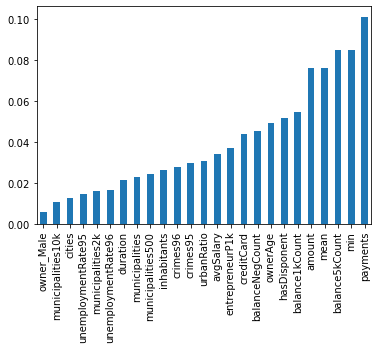

In [262]:
pd.Series(rf_random.best_estimator_.feature_importances_, index=X.columns).sort_values().plot(kind='bar');

## Gradient Boosting Classifier

{'n_estimators': 500}
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       182
           1       0.56      0.61      0.58        23

    accuracy                           0.90       205
   macro avg       0.76      0.77      0.76       205
weighted avg       0.91      0.90      0.90       205



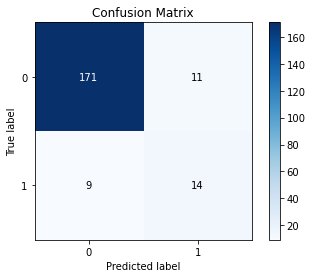

In [317]:
parameters = {
    'n_estimators' : [10, 50, 100, 500, 1000, 5000]
}

gb = GradientBoostingClassifier(random_state=42)

gs = GridSearchCV(gb, parameters, cv=StratifiedKFold(n_splits=5), scoring='f1', n_jobs=-1)
gs.fit(X_res, y_res)
print(gs.best_params_)
eval(gs.best_estimator_)

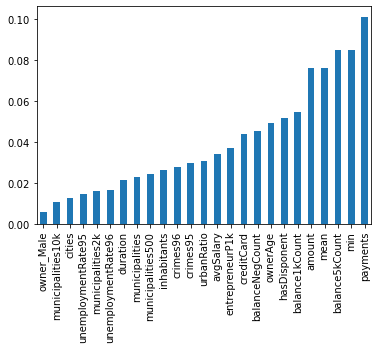

In [264]:
pd.Series(best_model.feature_importances_, index=X.columns).sort_values().plot(kind='bar');

## Features Selection

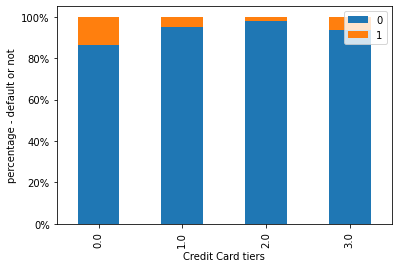

In [265]:
df.groupby(["creditCard", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="bar", stacked=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("percentage - default or not")
plt.xlabel("Credit Card tiers")
plt.legend(loc=1)
plt.show()

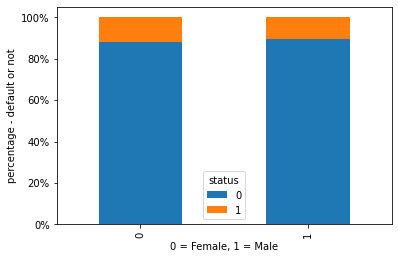

In [102]:
df.groupby(["owner_Male", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="bar", stacked=True)
plt.xlabel("0 = Female, 1 = Male")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("percentage - default or not")
plt.show()

status
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: ownerAge, dtype: object

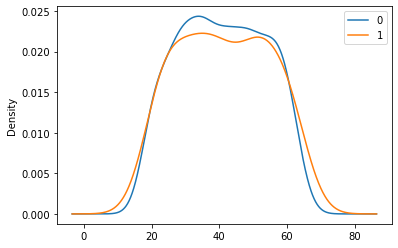

In [116]:
df.groupby('status')['ownerAge'].plot(kind='kde',legend=True)

## Important Features

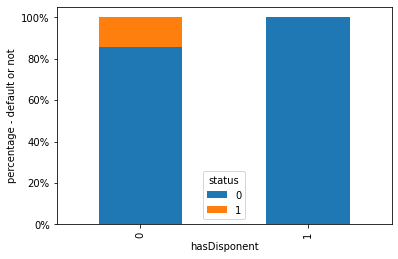

In [84]:
fig = df.groupby(["hasDisponent", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="bar", stacked=True)
plt.xlabel("hasDisponent")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("percentage - default or not")
plt.show()
fig.figure.savefig('hasDisponent.png')

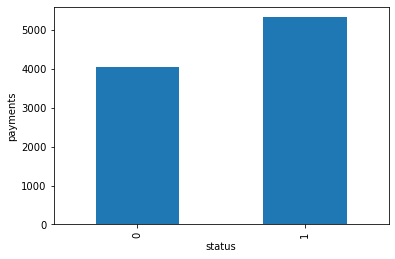

In [85]:
a = df.groupby(
    by="status", axis=0, level=None, as_index=True, sort=True, group_keys=True
)
fig = a['payments'].mean().plot(kind="bar")
plt.ylabel("payments")
fig.figure.savefig('payments.png')

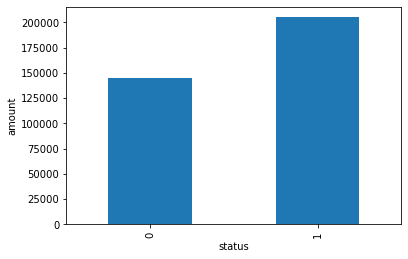

In [86]:
a = df.groupby(
    by="status", axis=0, level=None, as_index=True, sort=True, group_keys=True
)
fig = a['amount'].mean().plot(kind="bar")
plt.ylabel("amount")
fig.figure.savefig('loan amount.png')

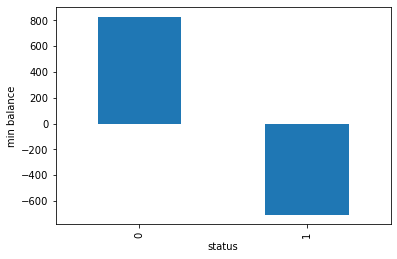

In [89]:
b = df.groupby(
    by="status", axis=0, level=None, as_index=True, sort=True, group_keys=True
)
fig = b['min'].mean().plot(kind="bar")
plt.ylabel("min balance")
fig.figure.savefig('min balance.png')

Text(0, 0.5, 'mean balance')

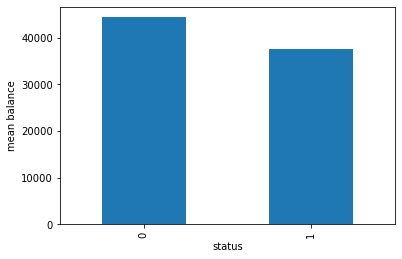

In [89]:
c = df.groupby(
    by="status", axis=0, level=None, as_index=True, sort=True, group_keys=True
)
c['mean'].mean().plot(kind="bar")
plt.ylabel("mean balance")

## Misclassified

In [280]:
misclassified = np.where(y_test != y_pred)
X_test.iloc[misclassified]

,amount,duration,payments,ownerAge,hasDisponent,creditCard,inhabitants,municipalities,municipalities500,municipalities2k,...,unemploymentRate95,unemploymentRate96,entrepreneurP1k,crimes95,crimes96,min,mean,balance5kCount,balance1kCount,owner_Male
29,196800.0,24,8200.0,39,0,0.0,112065,95,19,7,...,1.0,1.0,127,5179,4987,300.0,58669.565217,1.0,1.0,0
360,270648.0,36,7518.0,62,0,0.0,1204953,0,0,0,...,0.0,0.0,167,85677,99107,200.0,60819.972222,1.0,1.0,1
75,100080.0,48,2085.0,34,0,0.0,114200,101,41,4,...,6.0,6.0,105,2157,2718,300.0,22604.400000,1.0,1.0,0
648,385560.0,60,6426.0,43,0,0.0,102609,75,33,2,...,5.0,5.0,94,2123,2134,700.0,29028.338983,13.0,1.0,1
26,252060.0,60,4201.0,34,0,0.0,1204953,0,0,0,...,0.0,0.0,167,85677,99107,900.0,57340.688525,1.0,1.0,0


## Try few features

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       182
           1       0.73      0.35      0.47        23

    accuracy                           0.91       205
   macro avg       0.82      0.67      0.71       205
weighted avg       0.90      0.91      0.90       205



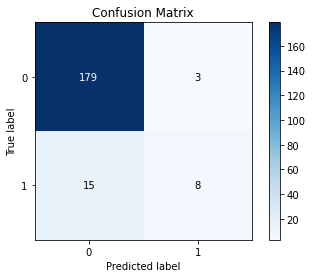

In [318]:
features = ['mean', 'min','hasDisponent','payments','amount','creditCard']
X_new = X[features]

scaler = MinMaxScaler()

X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y, test_size=0.30, stratify=y,random_state=42)

X_train_scaled = scaler.fit_transform(X_new_train)
X_test_scaled = scaler.transform(X_new_test)

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

bestmodel = LogisticRegression(C=1000)
bestmodel.fit(X_train_scaled, y_new_train)
eval(bestmodel)

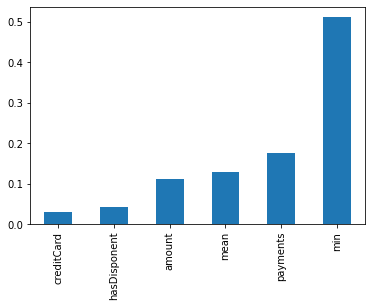

In [104]:
pd.Series(bestmodel.feature_importances_, index=features).sort_values().plot(kind='bar');

### Standard Scaler

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       182
           1       0.80      0.52      0.63        23

    accuracy                           0.93       205
   macro avg       0.87      0.75      0.80       205
weighted avg       0.93      0.93      0.93       205



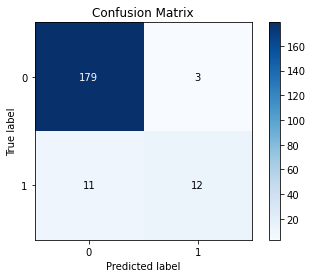

In [103]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y, test_size=0.30, stratify=y,random_state=42)

X_train_scaled = scaler.fit_transform(X_new_train)
X_test_scaled = scaler.transform(X_new_test)

bestmodel = GradientBoostingClassifier(n_estimators=50)
# bestmodel = RandomForestClassifier(n_estimators=800,min_samples_split=2,min_samples_leaf=2,max_features='sqrt',max_depth=50,bootstrap=False)
bestmodel.fit(X_train_scaled, y_new_train)

y_pred = bestmodel.predict(X_test_scaled)
print(classification_report(y_new_test,y_pred))
skplt.metrics.plot_confusion_matrix(y_new_test, y_pred)

### No Scaler

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       182
           1       0.76      0.57      0.65        23

    accuracy                           0.93       205
   macro avg       0.86      0.77      0.81       205
weighted avg       0.93      0.93      0.93       205



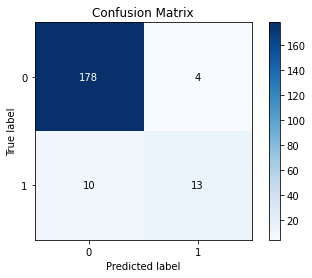

In [38]:
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y, test_size=0.30, stratify=y,random_state=42)

# bestmodel = GradientBoostingClassifier(n_estimators=50)
bestmodel = RandomForestClassifier(n_estimators=800,min_samples_split=2,min_samples_leaf=2,max_features='sqrt',max_depth=50,bootstrap=False)
bestmodel.fit(X_new_train, y_new_train)

y_pred = bestmodel.predict(X_new_test)
print(classification_report(y_new_test,y_pred))
skplt.metrics.plot_confusion_matrix(y_new_test, y_pred)

## Conclusion

- best model is RandomForest
- most important feature is min balance prior to loan
- most important scoring is the recall of label 1 because bank lose a lot of money when model predict not default but ends up default compared to the profit loss of rejecting a client who will not default
- scaler does not have any impact